In [1]:
import os

os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from internal.dataparsers.colmap_dataparser import Colmap, ColmapDataParser
import internal.utils.colmap as colmap_utils

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
dataset_path = os.path.expanduser("~/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0")

In [4]:
images = colmap_utils.read_images_binary(os.path.join(dataset_path, "sparse", "images.bin"))
cameras = colmap_utils.read_cameras_binary(os.path.join(dataset_path, "sparse", "cameras.bin"))
points = colmap_utils.read_points3D_binary(os.path.join(dataset_path, "sparse", "points3D.bin"))
images, cameras, points

({22928: Image(id=22928, qvec=array([0.41512482, 0.02730694, 0.80534472, 0.42230985]), tvec=array([ 0.25802596, -0.98088038,  3.24248351]), camera_id=17853, name='drone/Mavic2Pro/高角度全校3/DJI_0135.JPG', xys=array([[ 3.58365773e+02, -2.66313761e+00],
         [ 1.92244934e+03, -8.61658815e-01],
         [ 3.07467637e+01,  4.24413883e+00],
         ...,
         [ 1.36090364e+03,  4.88135293e+02],
         [ 1.46895432e+03,  9.90810046e+02],
         [ 1.14133053e+03,  9.97335431e+02]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1])),
  22927: Image(id=22927, qvec=array([0.37622163, 0.02886746, 0.8214488 , 0.42760475]), tvec=array([ 0.52254142, -0.97414563,  3.2097817 ]), camera_id=17853, name='drone/Mavic2Pro/高角度全校3/DJI_0134.JPG', xys=array([[ 1.07565416e+03, -4.90650114e+00],
         [ 3.09725845e+02,  9.00498309e-01],
         [ 3.20885749e+02,  1.10670220e+00],
         ...,
         [ 2.02905950e+03,  7.43633537e+02],
         [ 1.58661941e+03,  1.01278108e+03],
         [ 1.25047

In [5]:
R_list = []
T_list = []
fx_list = []
fy_list = []
cx_list = []
cy_list = []
width_list = []
height_list = []
image_name_list = []
image_id_to_index = {}  # map from image id in colmap database to index in tensor
image_index_to_id = {}

for idx, key in enumerate(images):
    extrinsics = images[key]
    image_id_to_index[extrinsics.id] = idx
    image_index_to_id[idx] = extrinsics.id
    image_name_list.append(extrinsics.name)
    intrinsics = cameras[extrinsics.camera_id]
    height = intrinsics.height
    width = intrinsics.width

    R = extrinsics.qvec2rotmat()
    T = np.array(extrinsics.tvec)
    if intrinsics.model == "SIMPLE_PINHOLE":
        focal_length_x = intrinsics.params[0]
        focal_length_y = focal_length_x
        cx = intrinsics.params[1]
        cy = intrinsics.params[2]
    elif intrinsics.model == "PINHOLE":
        focal_length_x = intrinsics.params[0]
        focal_length_y = intrinsics.params[1]
        cx = intrinsics.params[2]
        cy = intrinsics.params[3]
    else:
        assert False, "Colmap camera model not handled: only undistorted datasets (PINHOLE or SIMPLE_PINHOLE cameras) supported!"
    R_list.append(R)
    T_list.append(T)
    fx_list.append(focal_length_x)
    fy_list.append(focal_length_y)
    cx_list.append(cx)
    cy_list.append(cy)
    width_list.append(width)
    height_list.append(height)

R = torch.tensor(np.stack(R_list, axis=0), dtype=torch.float32)
T = torch.tensor(np.stack(T_list, axis=0), dtype=torch.float32)
fx = torch.tensor(fx_list, dtype=torch.float32)
fy = torch.tensor(fy_list, dtype=torch.float32)
cx = torch.tensor(cx_list, dtype=torch.float32)
cy = torch.tensor(cy_list, dtype=torch.float32)
width = torch.tensor(width_list, dtype=torch.int16)
height = torch.tensor(height_list, dtype=torch.int16)

In [6]:
# calculate camera-to-world transform matrix
w2c = torch.zeros(size=(R.shape[0], 4, 4))
w2c[:, :3, :3] = R
w2c[:, :3, 3] = T
w2c[:, 3, 3] = 1.
c2w = torch.linalg.inv(w2c)

In [7]:
# calculate reorient transform matrix
up = -torch.mean(c2w[:, :3, 1], dim=0)
up = up / torch.linalg.norm(up)

rotation = ColmapDataParser.rotation_matrix(up, torch.Tensor([0, 0, 1]))
rotation_transform = torch.eye(4)
rotation_transform[:3, :3] = rotation
up, rotation_transform

(tensor([-0.0038, -0.9156, -0.4020]),
 tensor([[ 1.0000, -0.0058,  0.0038,  0.0000],
         [-0.0058, -0.4019,  0.9156,  0.0000],
         [-0.0038, -0.9156, -0.4020,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]))

In [8]:
point_xyzs = []
point_rgbs = []
point_xyz_group_by_image_index = [[] for _ in range(len(R_list))]
min_visible_image = 3
max_error = 2.
for key in tqdm(points):
    point = points[key]
    if point.image_ids.shape[0] < min_visible_image:
        continue
    if point.error > max_error:
        continue
    for i in range(point.image_ids.shape[0]):
        image_id = point.image_ids[i]
        image_index = image_id_to_index[image_id]
        point_xyz_group_by_image_index[image_index].append(point.xyz)
    point_xyzs.append(point.xyz)
    point_rgbs.append(point.rgb)

point_xyzs = np.stack(point_xyzs)
point_rgbs = np.stack(point_rgbs)
for idx, i in enumerate(point_xyz_group_by_image_index):
    point_xyz_group_by_image_index[idx] = torch.tensor(np.stack(i))

point_xyzs.shape[0]

  0%|          | 0/2609978 [00:00<?, ?it/s]

2338223

In [9]:
reoriented_camera_centers = c2w[:, :3, 3] @ rotation_transform[:3, :3].T
reoriented_point_cloud_xyz = torch.tensor(point_xyzs, dtype=torch.float) @ rotation_transform[:3, :3].T

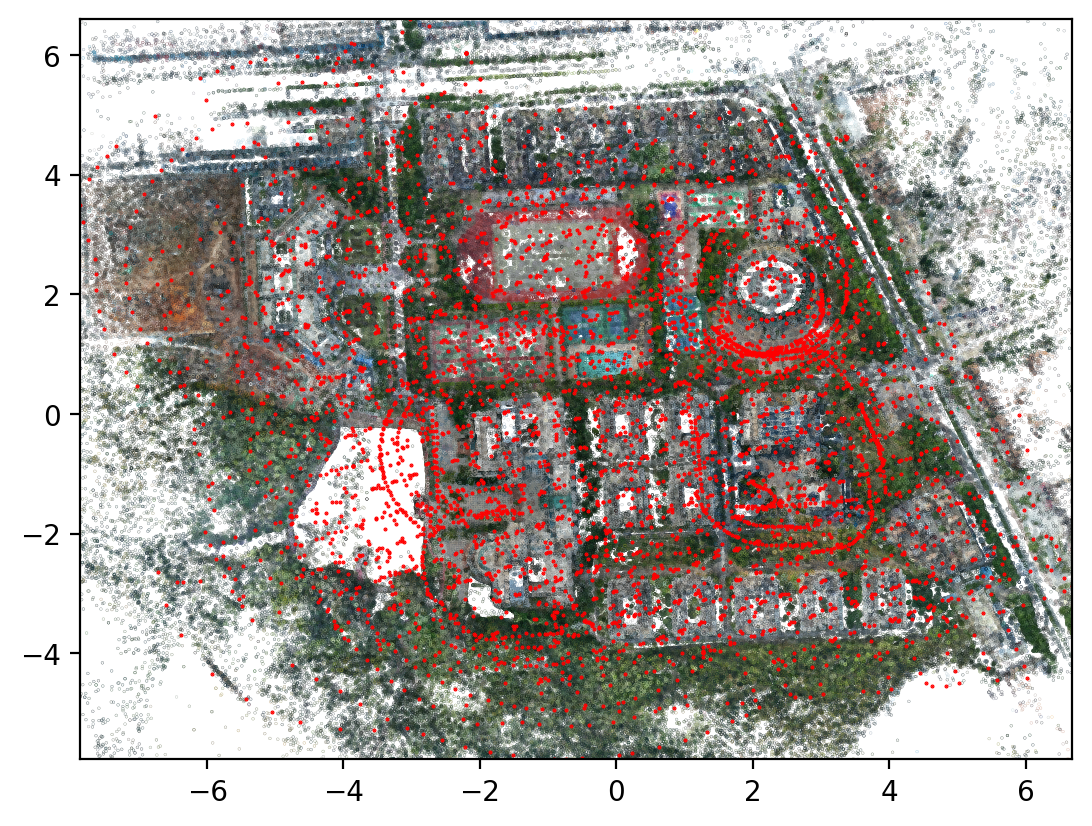

In [10]:
fig, ax = plt.subplots()
ax.set_xlim([torch.min(reoriented_camera_centers[:, 0]), torch.max(reoriented_camera_centers[:, 0])])
ax.set_ylim([torch.min(reoriented_camera_centers[:, 1]), torch.max(reoriented_camera_centers[:, 1])])
ax.scatter(reoriented_point_cloud_xyz[:, 0], reoriented_point_cloud_xyz[:, 1], c=point_rgbs / 255., s=0.01)
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2, c="red")
plt.show()

In [11]:
scene_center = torch.tensor([0., 0., 0.])  # scene center does not locate in the partition center, it is the corner
partition_radius = 1.5
torch.set_printoptions(precision=16)

In [12]:
# find scene bounding box
xyz_min = torch.min(reoriented_camera_centers, dim=0)[0]
xyz_max = torch.max(reoriented_camera_centers, dim=0)[0]
xyz_min, xyz_max

(tensor([-7.8559217453002930, -5.7590188980102539, -1.5457316637039185]),
 tensor([6.6817197799682617, 6.5958681106567383, 0.8511903285980225]))

In [13]:
# make bounding box align with the center one
def align_border(xyz):
    xyz_radius_factor = (xyz - scene_center) / (2 * partition_radius)
    xyz_ceil_radius_factor = torch.ceil(torch.abs(xyz_radius_factor)) * torch.sign(xyz_radius_factor)
    new_xyz = scene_center + xyz_ceil_radius_factor * 2 * partition_radius
    # xyz_min_radius_factor, xyz_min_ceil_radius_factor, new_xyz_min
    return new_xyz


partition_xyz_min = align_border(xyz_min)
partition_xyz_max = align_border(xyz_max)
partition_xyz_min, partition_xyz_max

(tensor([-9., -6., -3.]), tensor([9., 9., 3.]))

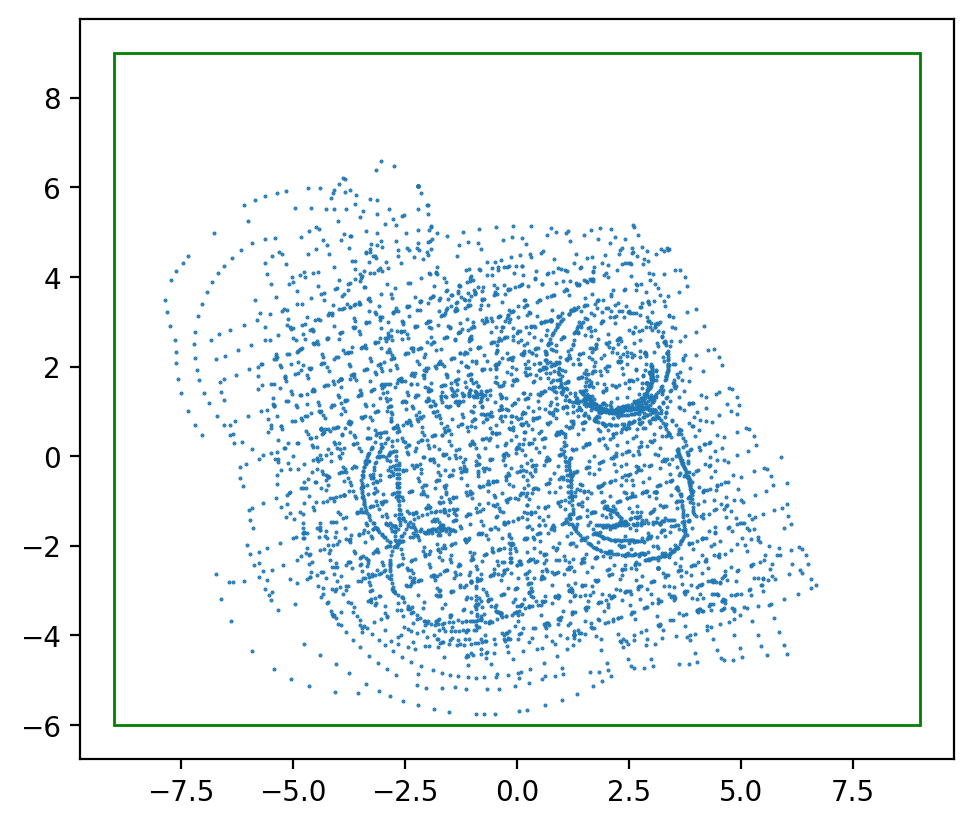

In [14]:
import matplotlib.patches as mpatches

plt.close()
fig, ax = plt.subplots()
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2)
ax.add_artist(mpatches.Rectangle(
    (partition_xyz_min[0], partition_xyz_min[1]),
    partition_xyz_max[0] - partition_xyz_min[0],
    partition_xyz_max[1] - partition_xyz_min[1],
    fill=False,
    color="green",
))
ax.set_xlim([partition_xyz_min[0] - 0.5 * partition_radius, partition_xyz_max[0] + 0.5 * partition_radius])
ax.set_ylim([partition_xyz_min[1] - 0.5 * partition_radius, partition_xyz_max[1] + 0.5 * partition_radius])
ax.set_aspect('equal', adjustable='box')
plt.show(fig)

In [15]:
# sometimes float division may not produce perfect integer, use torch.ceil() to make sure that all image are covered
partition_count = torch.ceil(((partition_xyz_max - partition_xyz_min) / (2 * partition_radius))).to(torch.int)
partition_count

tensor([6, 5, 2], dtype=torch.int32)

In [16]:
center_partition_offset = (
        torch.ceil((torch.abs(partition_xyz_min) / (2 * partition_radius))) * torch.sign(partition_xyz_min)).to(
    torch.int)
# center_partition_offset
grid_x, grid_y = torch.meshgrid(
    torch.arange(partition_count[0], dtype=torch.int) + center_partition_offset[0],
    torch.arange(partition_count[1], dtype=torch.int) + center_partition_offset[1],
    indexing="ij",
)
grid_x, grid_y  # build continuous grid coordinate for partitions, scene center is (0, 0)

(tensor([[-3, -3, -3, -3, -3],
         [-2, -2, -2, -2, -2],
         [-1, -1, -1, -1, -1],
         [ 0,  0,  0,  0,  0],
         [ 1,  1,  1,  1,  1],
         [ 2,  2,  2,  2,  2]], dtype=torch.int32),
 tensor([[-2, -1,  0,  1,  2],
         [-2, -1,  0,  1,  2],
         [-2, -1,  0,  1,  2],
         [-2, -1,  0,  1,  2],
         [-2, -1,  0,  1,  2],
         [-2, -1,  0,  1,  2]], dtype=torch.int32))

In [17]:
partition_xys = []  # bottom-left
partition_grid_xy = []
for i in range(partition_count[0]):
    for j in range(partition_count[1]):
        partition_xys.append(partition_xyz_min[:2] + torch.tensor([i * 2 * partition_radius, j * 2 * partition_radius]))
        partition_grid_xy.append((grid_x[i, j].item(), grid_y[i, j].item()))
# partition_xys = torch.stack(partition_xys)
partition_xys, partition_grid_xy

([tensor([-9., -6.]),
  tensor([-9., -3.]),
  tensor([-9.,  0.]),
  tensor([-9.,  3.]),
  tensor([-9.,  6.]),
  tensor([-6., -6.]),
  tensor([-6., -3.]),
  tensor([-6.,  0.]),
  tensor([-6.,  3.]),
  tensor([-6.,  6.]),
  tensor([-3., -6.]),
  tensor([-3., -3.]),
  tensor([-3.,  0.]),
  tensor([-3.,  3.]),
  tensor([-3.,  6.]),
  tensor([ 0., -6.]),
  tensor([ 0., -3.]),
  tensor([0., 0.]),
  tensor([0., 3.]),
  tensor([0., 6.]),
  tensor([ 3., -6.]),
  tensor([ 3., -3.]),
  tensor([3., 0.]),
  tensor([3., 3.]),
  tensor([3., 6.]),
  tensor([ 6., -6.]),
  tensor([ 6., -3.]),
  tensor([6., 0.]),
  tensor([6., 3.]),
  tensor([6., 6.])],
 [(-3, -2),
  (-3, -1),
  (-3, 0),
  (-3, 1),
  (-3, 2),
  (-2, -2),
  (-2, -1),
  (-2, 0),
  (-2, 1),
  (-2, 2),
  (-1, -2),
  (-1, -1),
  (-1, 0),
  (-1, 1),
  (-1, 2),
  (0, -2),
  (0, -1),
  (0, 0),
  (0, 1),
  (0, 2),
  (1, -2),
  (1, -1),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, -2),
  (2, -1),
  (2, 0),
  (2, 1),
  (2, 2)])

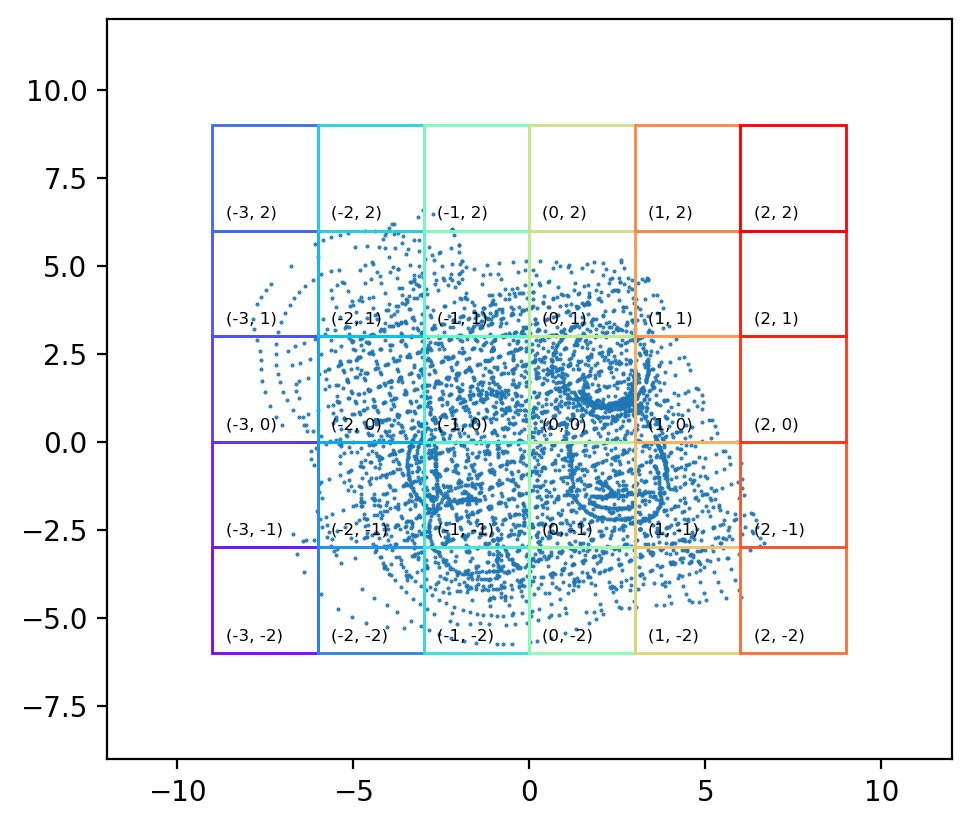

In [18]:
plt.close()
from matplotlib.pyplot import cm
import numpy as np

colors = list(iter(cm.rainbow(np.linspace(0, 1, len(partition_xys)))))
fig, ax = plt.subplots()
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2)
ax.set_xlim([partition_xyz_min[0] - 2 * partition_radius, partition_xyz_max[0] + 2 * partition_radius])
ax.set_ylim([partition_xyz_min[1] - 2 * partition_radius, partition_xyz_max[1] + 2 * partition_radius])
ax.set_aspect('equal', adjustable='box')

for idx, i in enumerate(partition_xys):
    ax.add_artist(mpatches.Rectangle(
        (i[0], i[1]),
        2 * partition_radius,
        2 * partition_radius,
        fill=False,
        color=colors[idx],
    ))
    ax.annotate("({}, {})".format(*partition_grid_xy[idx]),
                xy=(i[0] + 0.25 * partition_radius, i[1] + 0.25 * partition_radius), fontsize=6)

plt.show(fig)

In [31]:
is_image_in_partition_mask_list = []
is_image_see_partition_mask_list = []
partition_image_indices_list = []
enlarge = 0.2


def is_image_in_bounding_box(xy_min, xy_max):
    x_in_bounding_box = torch.logical_and(
        torch.ge(reoriented_camera_centers[:, 0], xy_min[0]),
        torch.le(reoriented_camera_centers[:, 0], xy_max[0]),
    )
    y_in_bounding_box = torch.logical_and(
        torch.ge(reoriented_camera_centers[:, 1], xy_min[1]),
        torch.le(reoriented_camera_centers[:, 1], xy_max[1]),
    )
    return torch.logical_and(x_in_bounding_box, y_in_bounding_box)


def get_image_point_cloud(frame_idx):
    return point_xyz_group_by_image_index[frame_idx].to(torch.float) @ rotation_transform[:3, :3].T


def is_points_inside_bounding_box(xy: torch.Tensor, xy_min: torch.Tensor, xy_max: torch.Tensor):
    is_x_or_y_inside = torch.logical_and(
        torch.ge(xy, xy_min),
        torch.le(xy, xy_max),
    )
    return torch.logical_and(is_x_or_y_inside[:, 0], is_x_or_y_inside[:, 1])


def is_image_see_bounding_box(
        in_bbox_mask,
        xy_min,
        xy_max,
        search_bbox_enlarge_ratio: float = 1.8,
        threshold: float = 0.25,
):
    """
    :param in_bbox_mask: 
    :param xy_min: 
    :param xy_max: 
    :param search_bbox_enlarge_ratio: 
    :param threshold: points_in_bounding_box/all_points > threshold, image will be added
    :return: 
    """

    # build enlarged bounding box
    xy_min_search = xy_min - search_bbox_enlarge_ratio * partition_radius
    xy_max_search = xy_max + search_bbox_enlarge_ratio * partition_radius
    # find images inside enlarged bounding box
    is_image_in_enlarged_bbox_mask = is_image_in_bounding_box(xy_min_search, xy_max_search)
    # exclude images inside original bounding box
    searchable_image_mask = torch.logical_and(is_image_in_enlarged_bbox_mask, torch.logical_not(in_bbox_mask))
    searchable_image_indices = torch.nonzero(searchable_image_mask).squeeze(-1).numpy().tolist()
    # calculate the percentage of the points that inside bounding box
    final_mask = torch.zeros_like(searchable_image_mask, dtype=torch.bool)
    for image_index in tqdm(searchable_image_indices, leave=False, desc="searching out-of-bbox images"):
        pc = get_image_point_cloud(image_index)
        inside_mask = is_points_inside_bounding_box(pc[:, :2], xy_min, xy_max)
        ratio = inside_mask.sum() / pc.shape[0]
        # add to list if >= threshold
        if ratio >= threshold:
            final_mask[image_index] = True
    # print("found: {}".format(searchable_image_indices.shape))
    return final_mask


for i in tqdm(partition_xys):
    xy_min = i
    xy_max = i + 2 * partition_radius
    xy_min_enlarged = i - enlarge * partition_radius
    xy_max_enlarged = i + (2 + enlarge) * partition_radius

    is_image_in_partition = is_image_in_bounding_box(xy_min, xy_max)
    is_image_see_partition = torch.zeros_like(is_image_in_partition)
    # only apply enlarging if it contains images
    if is_image_in_partition.sum().item() != 0:
        is_image_in_partition = is_image_in_bounding_box(xy_min_enlarged, xy_max_enlarged)
        is_image_see_partition = is_image_see_bounding_box(is_image_in_partition, xy_min, xy_max, threshold=0.1)
    is_image_in_partition_mask_list.append(is_image_in_partition)
    is_image_see_partition_mask_list.append(is_image_see_partition)
    image_indices = torch.nonzero(torch.logical_or(is_image_in_partition, is_image_see_partition)).squeeze(-1)
    partition_image_indices_list.append(image_indices)

is_image_in_partition_mask_list, partition_image_indices_list, [i.sum() for i in is_image_in_partition_mask_list]

  0%|          | 0/30 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/270 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/558 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/608 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/378 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/894 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1351 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1394 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/865 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/265 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1347 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/2403 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/2477 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1556 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/401 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1522 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/2464 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/2118 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1452 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/937 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1549 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1591 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/1033 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/375 [00:00<?, ?it/s]

searching out-of-bbox images:   0%|          | 0/538 [00:00<?, ?it/s]

([tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., False, False, False]),
  tensor([False, False, False,  ..., Fal

In [32]:
# print number of images of each partition
for partition_indices, partition_id in enumerate(partition_grid_xy):
    print(f"{partition_id}: {len(partition_image_indices_list[partition_indices])}")

(-3, -2): 7
(-3, -1): 34
(-3, 0): 140
(-3, 1): 52
(-3, 2): 0
(-2, -2): 174
(-2, -1): 556
(-2, 0): 746
(-2, 1): 375
(-2, 2): 44
(-1, -2): 562
(-1, -1): 1443
(-1, 0): 1158
(-1, 1): 544
(-1, 2): 25
(0, -2): 447
(0, -1): 1373
(0, 0): 1537
(0, 1): 485
(0, 2): 0
(1, -2): 268
(1, -1): 821
(1, 0): 637
(1, 1): 135
(1, 2): 0
(2, -2): 24
(2, -1): 66
(2, 0): 0
(2, 1): 0
(2, 2): 0


# Save

In [33]:
output_path = os.path.join(dataset_path, "partitions-threshold_0.1-search_enlarge_1.8")
os.makedirs(output_path, exist_ok=True)

In [34]:
partitions = {
    "orientation_transformation": rotation_transform,
    "radius": partition_radius,
    "xys": partition_xys,
    "ids": partition_grid_xy,
    "image_indices": partition_image_indices_list,
}
torch.save(partitions, os.path.join(output_path, "partitions.pt"))
partitions

{'orientation_transformation': tensor([[ 0.9999762177467346, -0.0057721207849681,  0.0037699241656810,
           0.0000000000000000],
         [-0.0057721207849681, -0.4019435644149780,  0.9156462550163269,
           0.0000000000000000],
         [-0.0037699241656810, -0.9156462550163269, -0.4019672870635986,
           0.0000000000000000],
         [ 0.0000000000000000,  0.0000000000000000,  0.0000000000000000,
           1.0000000000000000]]),
 'radius': 1.5,
 'xys': [tensor([-9., -6.]),
  tensor([-9., -3.]),
  tensor([-9.,  0.]),
  tensor([-9.,  3.]),
  tensor([-9.,  6.]),
  tensor([-6., -6.]),
  tensor([-6., -3.]),
  tensor([-6.,  0.]),
  tensor([-6.,  3.]),
  tensor([-6.,  6.]),
  tensor([-3., -6.]),
  tensor([-3., -3.]),
  tensor([-3.,  0.]),
  tensor([-3.,  3.]),
  tensor([-3.,  6.]),
  tensor([ 0., -6.]),
  tensor([ 0., -3.]),
  tensor([0., 0.]),
  tensor([0., 3.]),
  tensor([0., 6.]),
  tensor([ 3., -6.]),
  tensor([ 3., -3.]),
  tensor([3., 0.]),
  tensor([3., 3.]),
  tenso

In [35]:
for i in os.scandir(output_path):
    if not i.is_file():
        continue
    if i.name.endswith(".txt") or i.name.endswith(".json"):
        os.unlink(i.path)

image_list_file_name_list = []

for idx, i in enumerate(partition_image_indices_list):
    if len(i) < 32:
        continue
    id_string = "{:03d}_{:03d}".format(*partition_grid_xy[idx])
    camera_list = []
    image_list_file_name = os.path.join(output_path, f"{id_string}.txt")
    image_list_file_name_list.append(f"{id_string}.txt")
    with open(image_list_file_name, "w") as f:
        for image_index in i:
            f.write(image_name_list[image_index])
            f.write("\n")
            
            camera_list.append({
                "id": image_index.item(),
                "img_name": image_name_list[image_index],
                "width": width_list[image_index],
                "height": height_list[image_index],
                "position": c2w[image_index][:3, 3].numpy().tolist(),
                "rotation": c2w[image_index][:3, :3].numpy().tolist(),
                "fx": fx_list[image_index].item(),
                "fy": fy_list[image_index].item(),
            })

    with open(os.path.join(output_path, f"cameras_{id_string}.json"), "w") as f:
        json.dump(camera_list, f, indent=4, ensure_ascii=False)

with open(os.path.join(output_path, "image_lists.json"), "w") as f:
    json.dump(image_list_file_name_list, f, indent=4)

In [36]:
import open3d as o3d
final_pcd = o3d.geometry.PointCloud()
final_pcd.points = o3d.utility.Vector3dVector(point_xyzs)
final_pcd.colors = o3d.utility.Vector3dVector(point_rgbs / 255.)
o3d.io.write_point_cloud(os.path.join(output_path, "points.ply"), final_pcd)

True

# Preview

In [37]:
target_partition_idx = -1
for idx, i in enumerate(partition_grid_xy):
    if i == (-2, 0):
        target_partition_idx = idx
target_partition_idx

7

In [38]:
is_image_in_partition_mask_list[target_partition_idx].sum(), is_image_see_partition_mask_list[
    target_partition_idx].sum(), torch.logical_or(
    is_image_in_partition_mask_list[target_partition_idx], is_image_see_partition_mask_list[target_partition_idx]).sum()

(tensor(449), tensor(297), tensor(746))

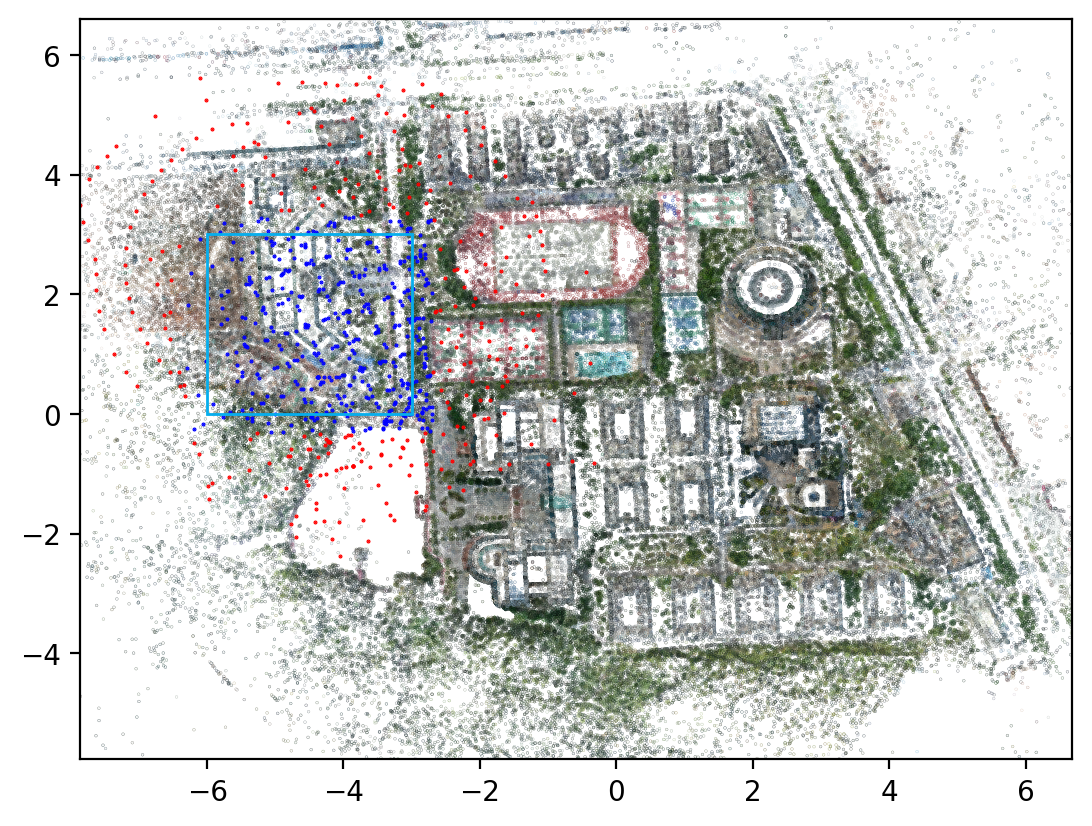

In [39]:
fig, ax = plt.subplots()
ax.scatter(reoriented_point_cloud_xyz[::8, 0], reoriented_point_cloud_xyz[::8, 1], c=point_rgbs[::8] / 255., s=0.01)
ax.scatter(
    reoriented_camera_centers[is_image_in_partition_mask_list[target_partition_idx], 0],
    reoriented_camera_centers[is_image_in_partition_mask_list[target_partition_idx], 1],
    s=0.2,
    c="blue",
)
ax.scatter(
    reoriented_camera_centers[is_image_see_partition_mask_list[target_partition_idx], 0],
    reoriented_camera_centers[is_image_see_partition_mask_list[target_partition_idx], 1],
    s=0.2,
    c="red",
)

ax.add_artist(mpatches.Rectangle(
    (partition_xys[target_partition_idx][0], partition_xys[target_partition_idx][1]),
    2 * partition_radius,
    2 * partition_radius,
    fill=False,
    color=colors[target_partition_idx],
))

ax.set_xlim([torch.min(reoriented_camera_centers[:, 0]), torch.max(reoriented_camera_centers[:, 0])])
ax.set_ylim([torch.min(reoriented_camera_centers[:, 1]), torch.max(reoriented_camera_centers[:, 1])])

# ax.annotate("({}, {})".format(*partition_grid_xy[target_partition_idx]),
#             xy=(i[0] + 0.25 * partition_radius, i[1] + 0.25 * partition_radius), fontsize=6)

plt.show()